Introduction
=========

A first attempt for assignment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import gpflow
import datetime

2023-11-14 16:17:31.413523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

TF version: 2.10.1
TFP version: 0.18.0


In [64]:
from probabilistic_models_archive.prior import sg_prior, gmm_prior
from probabilistic_models_archive.posterior import posterior
from probabilistic_models_archive.utils import nll

ModuleNotFoundError: No module named 'probabilistic_models_archive'

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('../data/raw/smedebtsu.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     84 non-null     object 
 1   Day      84 non-null     int64  
 2   Month    84 non-null     int64  
 3   Year     84 non-null     int64  
 4   LenderA  84 non-null     float64
 5   LenderB  84 non-null     float64
 6   LenderC  84 non-null     float64
 7   LenderD  84 non-null     int64  
 8   LenderE  84 non-null     float64
 9   LenderF  84 non-null     float64
 10  LenderG  84 non-null     float64
 11  LenderH  84 non-null     float64
 12  LenderI  84 non-null     float64
 13  LenderJ  84 non-null     float64
 14  LenderK  84 non-null     float64
 15  totalU   84 non-null     float64
dtypes: float64(11), int64(4), object(1)
memory usage: 10.6+ KB


### clean date format

In [5]:
# identifying rows with wrong date formatting

m = pd.to_datetime(data['Date'], format="%d/%m/%Y", errors='coerce').isna()

In [6]:
print("Rows with wrong date format:", data.loc[m, 'Date'].unique().tolist())

Rows with wrong date format: ['04/042022', '02/052022']


In [7]:
print(data[data['Date'] == '04/042022'].index)

Index([73], dtype='int64')


In [8]:
print(data[data['Date'] == '02/052022'].index)

Index([74, 75], dtype='int64')


In [9]:
data.loc[73, 'Date'] = "04/04/2022"
data.loc[74, 'Date'] = "02/05/2022"
data.loc[75, 'Date'] = "02/05/2022"

In [10]:
data["datetime"] = pd.to_datetime(data['Date'], format="%d/%m/%Y")

In [11]:
data.head()

,Date,Day,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU,datetime
0,13/10/2013,13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01,2013-10-13
1,13/11/2013,13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31,2013-11-13
2,10/12/2013,10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00,2013-12-10
3,23/01/2014,23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00,2014-01-23
4,05/03/2014,5,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00,2014-03-05


In [12]:
data_clean = data.set_index('datetime').drop(['Day', 'Date'], axis=1)

In [13]:
data_clean.head()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00


In [14]:
data_clean.shape

(84, 14)

### check missing data

In [15]:
data_clean.isna().sum()

Month      0
Year       0
LenderA    0
LenderB    0
LenderC    0
LenderD    0
LenderE    0
LenderF    0
LenderG    0
LenderH    0
LenderI    0
LenderJ    0
LenderK    0
totalU     0
dtype: int64

conclusion: currently, there is no missing data. However, in the cases there are, we can show the places for missing data

In [16]:
# data_clean.query('data_clean.isna()')

In [17]:
# check for missing months

In [18]:
data_clean

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.00,0.00,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.00,0.00,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.00,0.00,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.00,0.00,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.00,0.00,0.00,0.0,0.00,290103.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,11,2022,28369.0,115775.00,0.00,0,245740.0,22638.00,62084.00,104335.00,14025.00,19800.0,0.00,612766.00
2023-02-05,2,2023,26774.0,108064.00,0.00,0,234740.0,15125.00,57772.00,98703.00,8800.00,15400.0,0.00,565378.00
2023-03-05,3,2023,26202.0,104225.00,0.00,0,231077.0,11352.00,56826.00,95810.00,5500.00,13200.0,0.00,544192.00


In [19]:
def find_missing_months(df):
    """ look for months with missing records from the history 
    
    args:
        df: the query dataframe
        
    return:
        information (stdout) as to missing months
    """
    
    s = df.resample('MS').size()
    mm = s[s == 0].index.to_period('M')
    num = len(mm)
    print(f"Number of monthly missing records: {num}")
    print(mm)

In [20]:
find_missing_months(data_clean)

Number of monthly missing records: 33
PeriodIndex(['2014-02', '2015-06', '2015-07', '2015-09', '2016-03', '2016-04',
             '2017-06', '2017-08', '2018-01', '2018-02', '2018-04', '2018-06',
             '2018-08', '2018-10', '2019-02', '2019-06', '2020-01', '2020-05',
             '2020-07', '2020-09', '2020-10', '2020-11', '2021-01', '2021-02',
             '2021-03', '2021-05', '2021-06', '2021-08', '2022-02', '2022-06',
             '2022-07', '2022-12', '2023-01'],
            dtype='period[M]', name='datetime')


In [21]:
# # failed attempt
# min = data_clean.index.min().date()
# max = data_clean.index.max().date()
# pd.date_range(start=min, end=max, freq='M')

### check duplicated data

In [22]:
data_clean.duplicated().sum()

0

In [23]:
# display the duplicated rows if there exist

data_clean[data_clean.duplicated()]

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,


In [24]:
data_clean.head()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00


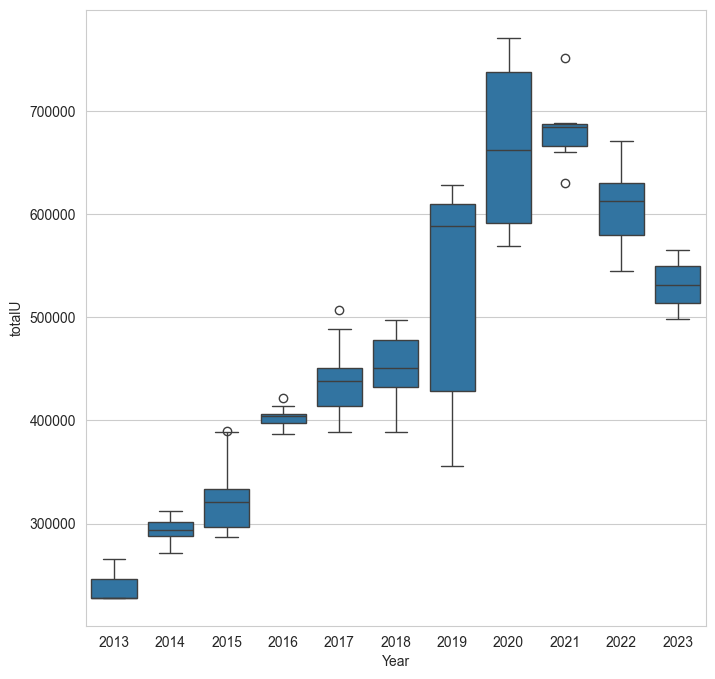

In [25]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.boxplot(
    data=data_clean, 
    y='totalU', 
    x='Year', 
)

In [26]:
data_clean.shape

(84, 14)

### data exploration

In [27]:
monthly_data = data_clean[data_clean['Year'] == 2013]

In [28]:
monthly_data

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00


In [29]:
def year_average_plot(ax, df, title):

    # plotting style
    ax.plot(df.Month, 
            df.totalU, 
            color='black', 
            marker='o', 
            linestyle='-',
            linewidth=2, 
            mfc = 'salmon',
            mec = None,
            markersize=8,
           )
    ax.grid(which='both')
    ax.set_title(f'{title}')
    
    # x-axis formatting
    ax.set_xlim(0, 13)
    ax.xaxis.set_major_locator(
        mpl.ticker.FixedLocator(np.arange(1,13)))
    
    # y-axis formatting
    ax.set_ylim(200000, 800000)
    ax.yaxis.set_major_locator(
        mpl.ticker.FixedLocator(
            [300000, 400000, 500000, 600000, 700000]))
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.yaxis.set_minor_locator(
        mpl.ticker.AutoMinorLocator(n=2))

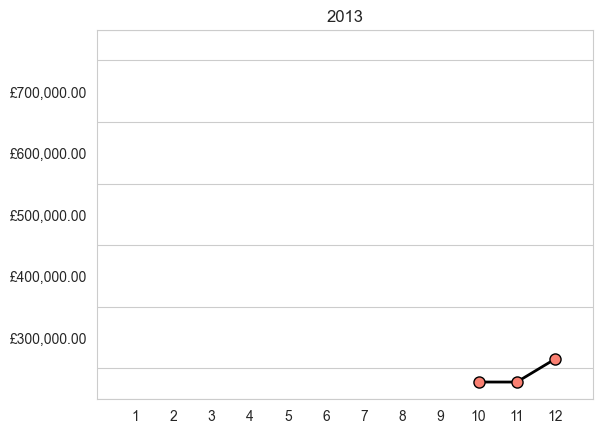

In [30]:
fig, ax = plt.subplots()
year_average_plot(ax, monthly_data, title='2013')

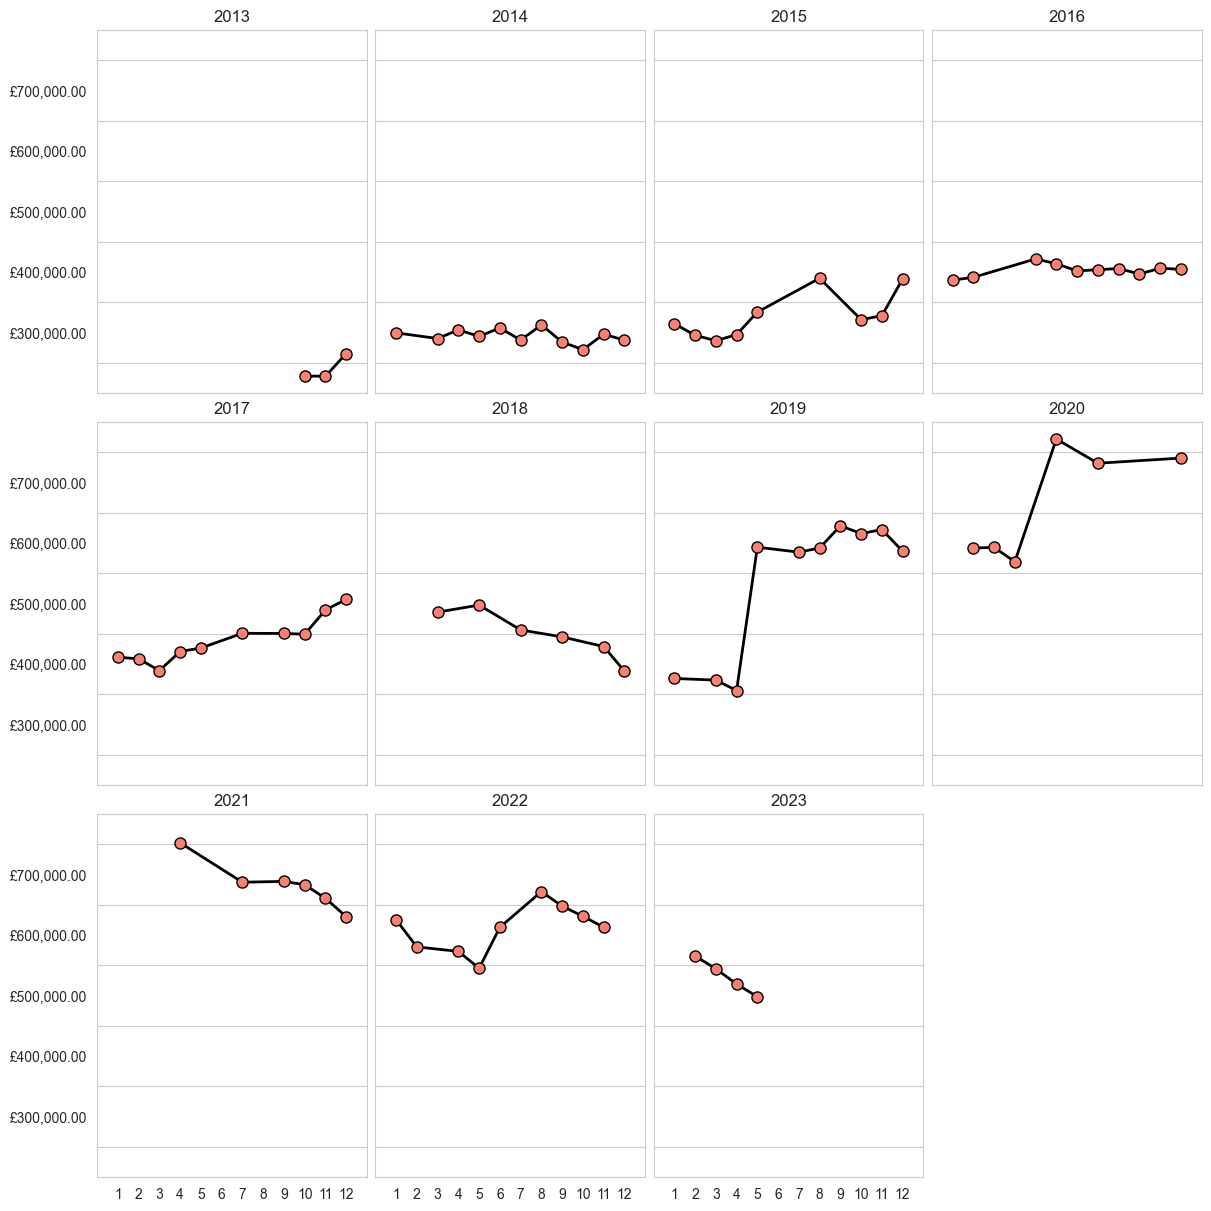

In [31]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, 
    sharex=True, sharey=True,
    layout="constrained",
    figsize=(12, 12))

monthly_data_gen = (data_clean[data_clean['Year'] == year] for year in range(2013, 2024))
year_gen = iter(range(2013, 2024))
    
for row in range(4):
    for col in range(4):
        try: 
            year_average_plot(ax=axs[row, col], df=next(monthly_data_gen), title=next(year_gen))
        except Exception:
            pass
        
fig.delaxes(axs[2][3])
plt.show()

In [32]:
# # pandas quick plotting method
# data_clean['totalU'].plot()

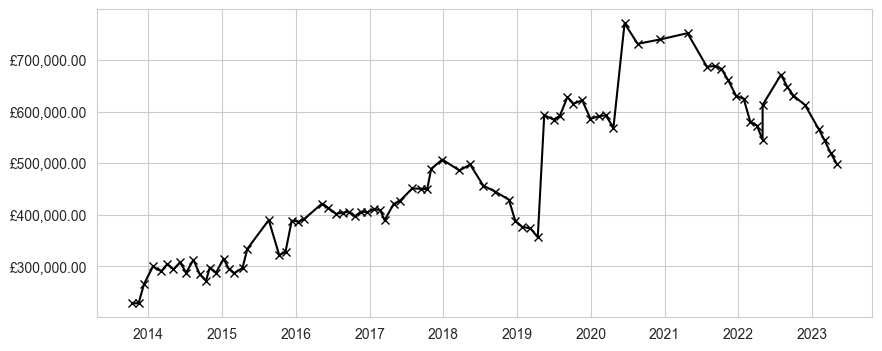

In [33]:
fig, ax  = plt.subplots(figsize=(10, 4))
ax.plot(data_clean.index, data_clean['totalU'], 'k-x')
ax.yaxis.set_major_formatter('£{x:,.2f}')

# Modelling

In [34]:
## GP modelling

In [35]:
data_clean.head()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00


In [36]:
data_clean.tail()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2022-11-28,11,2022,28369.0,115775.0,0.0,0,245740.0,22638.0,62084.00,104335.00,14025.0,19800.0,0.0,612766.00
2023-02-05,2,2023,26774.0,108064.0,0.0,0,234740.0,15125.0,57772.00,98703.00,8800.0,15400.0,0.0,565378.00
2023-03-05,3,2023,26202.0,104225.0,0.0,0,231077.0,11352.0,56826.00,95810.00,5500.0,13200.0,0.0,544192.00
2023-04-05,4,2023,25432.0,100375.0,0.0,0,227403.0,7579.0,54618.08,92689.96,0.0,11000.0,0.0,519097.04
2023-05-05,5,2023,24893.0,95975.0,0.0,0,223729.0,3773.0,51876.00,89023.00,0.0,8800.0,0.0,498069.00


In [37]:
# def transform_X(df):
#     """ from date format into numeric format """
#     return (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)

In [38]:
def prepare_training_data(df):

    y = data_clean[['totalU']].to_numpy().reshape(-1, 1)
    y = y - y.mean()
    X = (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)
    
    return X, y

In [39]:
X, y = prepare_training_data(data_clean)

In [40]:
X.shape

(84, 1)

In [41]:
y.shape

(84, 1)

In [42]:
today = datetime.datetime.now()
current_month = today.year + today.month / 12

In [43]:
start = data_clean.index.min()
start_month = start.year + start.month / 12
start_month

2013.8333333333333

In [44]:
X_test = np.linspace(start=start_month, stop=current_month, num=200).reshape(-1, 1)

### GP modelling

In [45]:
# get the zero-mean process
model = gpflow.models.GPR(
    (X, y),
    kernel=gpflow.kernels.SquaredExponential()
    + gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=1.0),
    # likelihood=gpflow.likelihoods.Gaussian(scale=gpflow.functions.Polynomial(degree=2)),
    noise_variance = 10_000,
)

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

2023-11-14 16:17:39.389638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1063.512906439961
        x: [ 7.219e-01  1.445e+09  2.545e+03 -2.862e+02  6.246e+08
             6.270e+08]
      nit: 79
      jac: [-2.384e-08 -2.092e-08  0.000e+00  0.000e+00 -1.906e-08
            -2.106e-08]
     nfev: 149
     njev: 149
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [46]:
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.44521e+09
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.11789
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,6.24613e+08
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0
GPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,2545.5
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,6.26998e+08


In [47]:
f_mean, f_var = model.predict_f(X_test, full_cov=False)

In [48]:
f_lower = f_mean - 1.96 * np.sqrt(f_var)
f_upper = f_mean + 1.96 * np.sqrt(f_var)

In [49]:
y_mean, y_var = model.predict_y(X_test)

In [50]:
# f_mean

In [51]:
# y_var

In [52]:
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

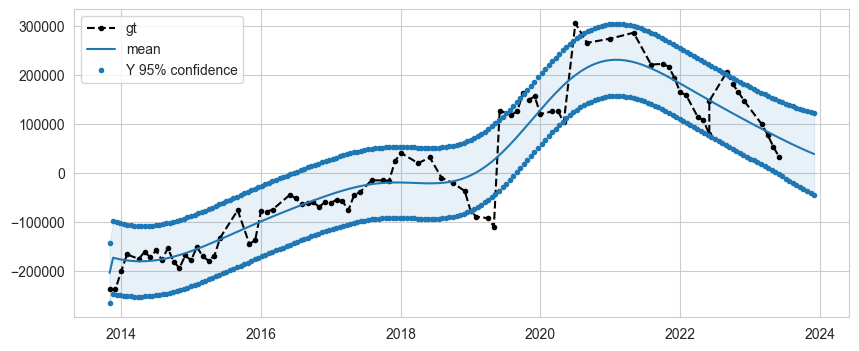

In [53]:
plt.figure(figsize=(10, 4))
plt.plot(X, y, color="black", linestyle="dashed", label="gt", marker='.')

# plt.plot(X, Y, "kx", mew=2, label="input data")

plt.plot(X_test, f_mean, "-", color="C0", label="mean")
# plt.plot(X_test, f_lower, "--", color="C0", label="f 95% confidence")
# plt.plot(X_test, f_upper, "--", color="C0")
# plt.fill_between(
#     X_test[:, 0], f_lower[:, 0], f_upper[:, 0], color="C0", alpha=0.1
# )

plt.plot(X_test, y_lower, ".", color="C0", label="Y 95% confidence")
plt.plot(X_test, y_upper, ".", color="C0")
plt.fill_between(
    X_test[:, 0], y_lower[:, 0], y_upper[:, 0], color="C0", alpha=0.1
)
plt.legend()


### Bayesian NN 

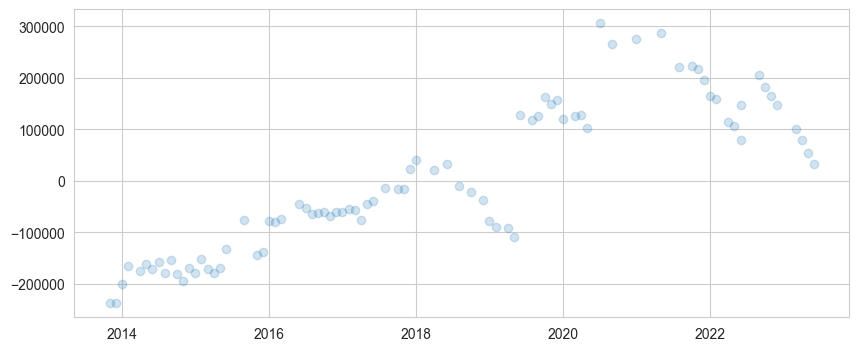

In [60]:
plt.figure(figsize=(10, 4))
plt.scatter(X, y, alpha=0.2)
plt.show()

In [63]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model_BNN = Sequential([
    tfpl.DenseVariational(units=32,
                          input_shape=(1,),
                          make_prior_fn=sg_prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=sg_prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))

NameError: name 'sg_prior' is not defined

In [54]:
## Machine Learning models in an autoregressive scheme

In [55]:
# a table showing the accuracy metrics